In [36]:
import argparse
import yaml
from models import dist_util, logger
from models.image_datasets import load_data
from models.resample import create_named_schedule_sampler
from models.script_util import (
    model_and_diffusion_defaults,
    encoder_defaults,
    create_model_and_diffusion,
    create_encoder,
    select_config,
    create_diffusion
)
from models.train_util import TrainLoop

### load config file

In [37]:
with open('configs/cifar10.yaml', 'r') as f:
    try:
        config = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(exc)
print(config)

{'num_classes': 10, 'dataset': 'cifar10', 'data_dir': '../data/cifar_train', 'log_dir': './jscc_log', 'model_path': './jscc_log/model100000.pt', 'encoder_path': './log/encoder010000.pt', 'jscc_encoder_path': './jscc_log/encoder100000.pt', 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.0, 'lr_anneal_steps': 100000, 'batch_size': 64, 'microbatch': -1, 'ema_rate': 0.9999, 'log_interval': 10, 'save_interval': 50000, 'resume_checkpoint': '', 'use_fp16': False, 'fp16_scale_growth': '1e-3', 'image_size': 32, 'num_channels': 128, 'num_res_blocks': 3, 'num_heads': 4, 'num_heads_upsample': -1, 'attention_resolutions': '16,8', 'learn_sigma': True, 'diffusion_steps': 4000, 'noise_schedule': 'cosine', 'schedule_sampler': 'uniform', 'sigma_small': False, 'class_cond': True, 'timestep_respacing': '', 'use_kl': False, 'predict_xstart': False, 'rescale_timesteps': True, 'rescale_learned_sigmas': True, 'use_checkpoint': False, 'use_scale_shift_norm': True, 'num_samples': 100, 'clip_denoised': True, 'us

In [38]:
# distributed training
dist_util.setup_dist()

In [39]:
model, diffusion = create_model_and_diffusion(
        **select_config(config, model_and_diffusion_defaults().keys())
    )
model.to(dist_util.dev())

# Unet encoder
encoder = create_encoder(**select_config(config, encoder_defaults().keys()))
encoder.to(dist_util.dev())

schedule_sampler = create_named_schedule_sampler(config['schedule_sampler'], diffusion)

In [40]:
# load the data
data = load_data(
    data_dir=config['data_dir'],
    batch_size=config['batch_size'],
    image_size=config['image_size'],
    class_cond=config['class_cond'],
)

In [41]:
batch, cond = next(data)
batch = batch.to(dist_util.dev())
cond['y'] = cond['y'].to(dist_util.dev())

In [42]:
# test JSCC encoder
from models.autoencoder import JSCC_encoder

jscc_encoder = JSCC_encoder(hidden_dims=config['hidden_dims'])
jscc_encoder.to(dist_util.dev())

JSCC_encoder(
  (out): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(96, 512, kernel_size=(4, 4), 

In [43]:
encoder(batch).shape, jscc_encoder(batch).shape

(torch.Size([64, 512]), torch.Size([64, 512]))

In [44]:
z = encoder(batch, y=cond['y'])

### Load the checkpoint

In [45]:
model.load_state_dict(
        dist_util.load_state_dict(config['model_path'], map_location="cpu")
    )

<All keys matched successfully>

In [46]:
encoder.load_state_dict(
        dist_util.load_state_dict(config['encoder_path'], map_location="cpu")
)

jscc_encoder.load_state_dict(
        dist_util.load_state_dict(config['jscc_encoder_path'], map_location="cpu")
)

<All keys matched successfully>

In [47]:
model_kwargs = {}
model_kwargs["y"] = cond['y']
z = jscc_encoder(batch)
model_kwargs["latent"] = z

In [48]:
# diffusion = create_diffusion(config, T=250)
# out = diffusion.ddim_reverse_sample_loop(model,
#                                         batch,
#                                         model_kwargs=model_kwargs)
from models.script_util import create_reverse_process, create_sampler
reverse_func = create_reverse_process(config, T=250)
out = reverse_func(model, batch, model_kwargs=model_kwargs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


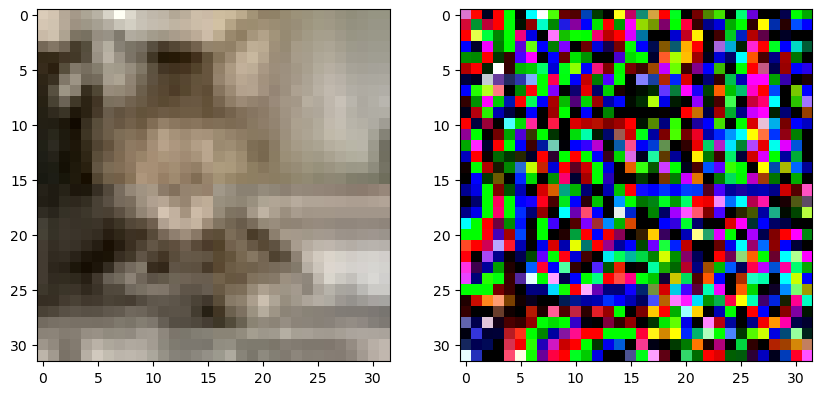

In [49]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
xT = out['sample']
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

In [50]:
# diffusion = create_diffusion(config, T=250)
# sample_fn = (
#             diffusion.p_sample_loop if not config['use_ddim'] else diffusion.ddim_sample_loop
#         )
sample_fn = create_sampler(config, T=250)
# use start noise
sample = sample_fn(
    model,
    (config['batch_size'], 3, config['image_size'], config['image_size']),
    noise=xT,
    clip_denoised=config['clip_denoised'],
    model_kwargs=model_kwargs,
)
sample = (sample + 1) / 2

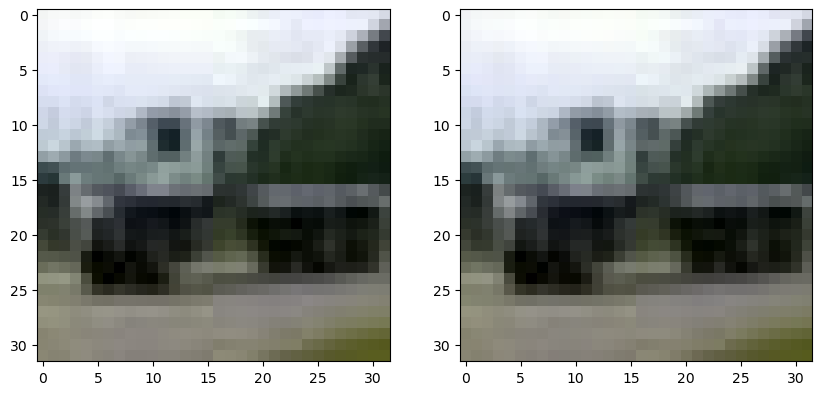

In [51]:
idx = 30
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ori[idx].permute(1, 2, 0).cpu())
ax[1].imshow(sample[idx].permute(1, 2, 0).cpu())

In [52]:
# sample_fn = (
#             diffusion.p_sample_loop if not config['use_ddim'] else diffusion.ddim_sample_loop
#         )
# sample = sample_fn(
#     model,
#     (config['batch_size'], 3, config['image_size'], config['image_size']),
#     noise=xT,
#     clip_denoised=config['clip_denoised'],
#     model_kwargs=model_kwargs,
# )
# sample = ((sample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
# sample = sample.permute(0, 2, 3, 1)
# sample = sample.contiguous()

In [53]:
# sample_grid = make_grid(sample.permute(0, 3, 1, 2), nrow=int(np.sqrt(config['batch_size'])))

# plt.figure(figsize=(6,6))
# plt.axis('off')
# # plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
# plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0, vmax=255)
# plt.show()

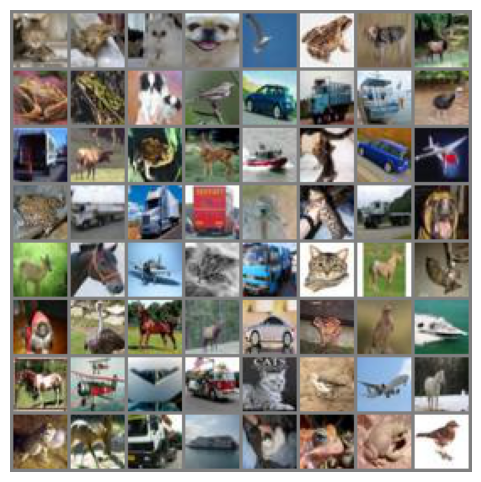

In [54]:
from torchvision.utils import save_image, make_grid 
import matplotlib.pyplot as plt
import numpy as np

sample_grid = make_grid(batch.view(-1, 3, 32, 32), nrow=int(np.sqrt(batch.shape[0])))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow((sample_grid.permute(1, 2, 0).cpu()+1)/2, vmin=0., vmax=1.)
plt.show()

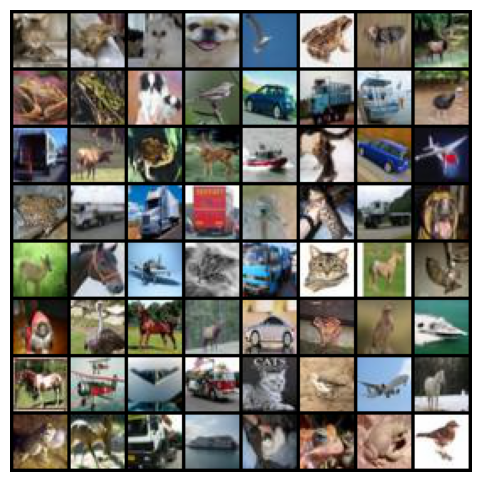

In [55]:
sample_grid = make_grid(sample, nrow=int(np.sqrt(config['batch_size'])))

plt.figure(figsize=(6,6))
plt.axis('off')
# plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [56]:
# use Gaussian noise
sample = sample_fn(
    model,
    (config['batch_size'], 3, config['image_size'], config['image_size']),
    clip_denoised=config['clip_denoised'],
    model_kwargs=model_kwargs,
)
sample = (sample + 1) / 2

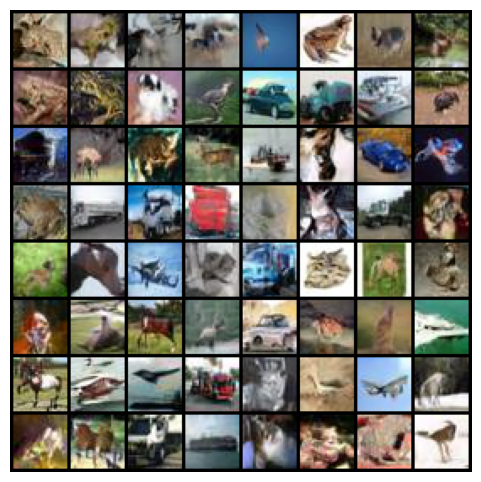

In [57]:
sample_grid = make_grid(sample, nrow=int(np.sqrt(config['batch_size'])))

plt.figure(figsize=(6,6))
plt.axis('off')
# plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()